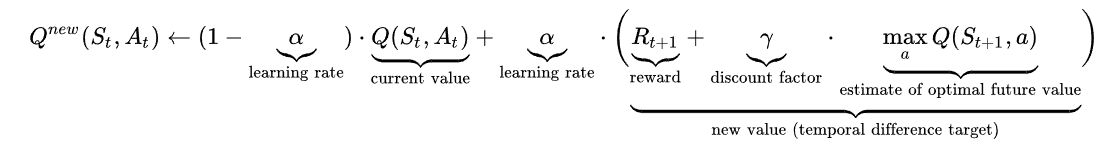

## Q-Table vs Tile Coding

This notebook demonstrates two approaches to discretizing continuous state spaces:
1. **Simple Discretization (Q-Table)**: Single grid with fixed bins
2. **Tile Coding**: Multiple overlapping grids for smoother generalization

In [1]:
import gymnasium as gym
import matplotlib.pyplot as plt
import numpy as np
from plot_utils import plot_durations, plot_states_over_time, setup_matplotlib
from q_table import QTable, TileCoding

In [2]:
# get environment
env = gym.make('CartPole-v1', render_mode='rgb_array')

# Q table
pos_space = np.linspace(-2.4, 2.4, 10)
vel_space = np.linspace(-4, 4, 10)
ang_space = np.linspace(-0.2095, 0.2095, 15)
ang_vel_space = np.linspace(-4, 4, 15)

q_table = QTable(env, [pos_space, vel_space, ang_space, ang_vel_space], env.action_space.n)

Complete


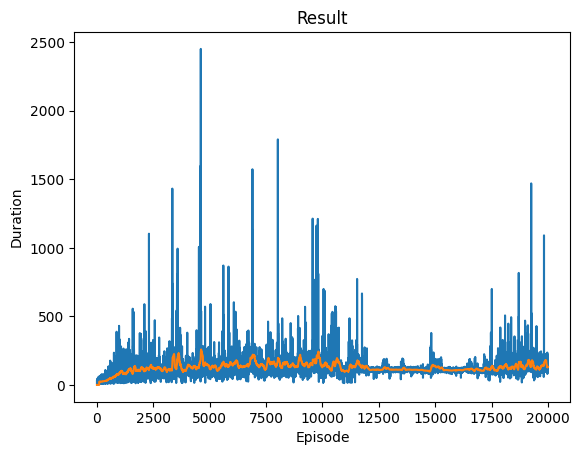

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [3]:
# set up matplotlib
setup_matplotlib()

episode_durations = []

# Q learning
total_rewards = 0
for episode in range(20000):
    state = env.reset()[0]

    terminated = False
    episode_reward = 0
    while not terminated:
        action = q_table.choose_action(state)

        new_state, reward, terminated, truncated, info = env.step(action)

        if not terminated:  # update q-table
            q_table.update_q_table(state, action, reward, new_state)
        episode_reward += reward
        state = new_state

    episode_durations.append(episode_reward)

    q_table.update_exploration_rate()
    if episode % 100 == 0:
        print(
            f'Episode: {episode}, reward: {episode_reward}, exploration rate: {q_table.exploration_rate}'
        )

    plot_durations(episode_durations)

    total_rewards += episode_reward
    if total_rewards / (episode + 1) > 1000:
        break

print('Complete')
plot_durations(episode_durations, show_result=True)
plt.ioff()
plt.show()

env.close()

q_trained = q_table

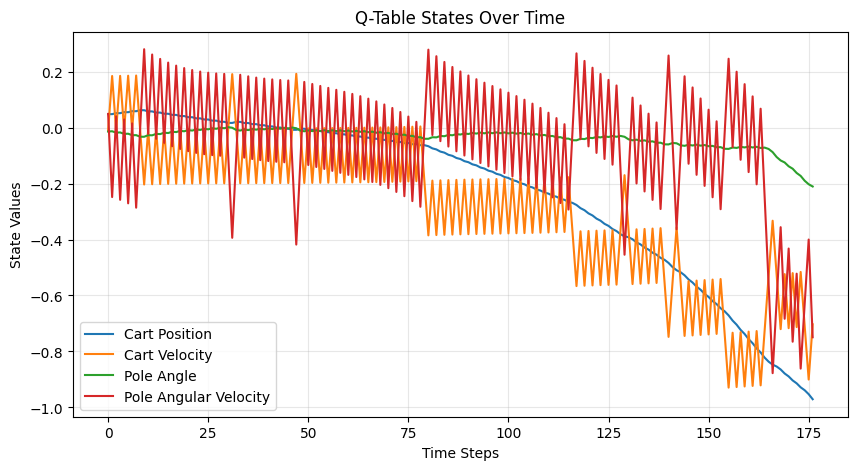

In [6]:
# get environment
final_env = gym.make('CartPole-v1', render_mode='human')

# Run one episode to capture states for visualization
state_history = []
state = final_env.reset()[0]

terminated = False
while not terminated:
    state_history.append(state)
    action = q_trained.choose_action(state, explore=False)
    state, reward, terminated, truncated, info = final_env.step(action)
    terminated = terminated or truncated

state_history.append(state)

# Plot the states over time
state_history = np.array(state_history)
plot_states_over_time(state_history, title='Q-Table States Over Time')
final_env.close()

## Tile Coding

In [9]:
# Create environment for tile coding
tile_env = gym.make('CartPole-v1', render_mode='rgb_array')

# Define state bounds for CartPole
# [cart position, cart velocity, pole angle, pole angular velocity]
state_bounds = [
    (-2.4, 2.4),  # cart position
    (-2.5, 2.5),  # cart velocity
    (-0.21, 0.21),  # pole angle (radians)
    (-2.5, 2.5),  # pole angular velocity
]

# Create tile coding agent
tile_agent = TileCoding(
    env=tile_env,
    state_bounds=state_bounds,
    n_tilings=8,
    n_tiles_per_dim=10,
    learning_rate=0.1,
    discount_factor=0.99,
    exploration_rate=1.0,
    exploration_decay_rate=0.995,
)

Solved in 773 episodes!
Complete


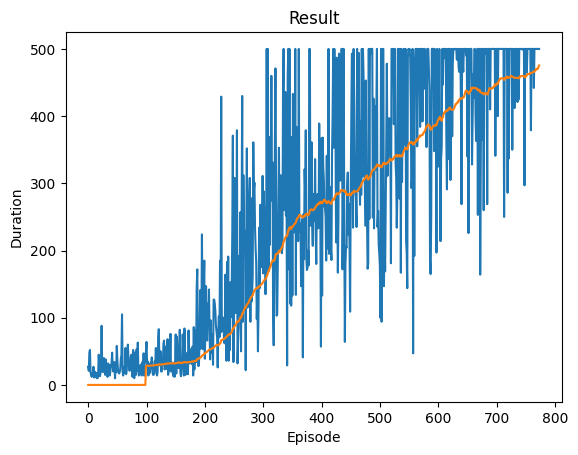

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [10]:
# Set up matplotlib for tile coding
setup_matplotlib()

tile_episode_durations = []

# Training loop for tile coding
max_episodes = 2000
for episode in range(max_episodes):
    state, info = tile_env.reset()

    terminated = False
    episode_reward = 0

    while not terminated:
        # Choose action
        action = tile_agent.choose_action(state)

        # Take action
        next_state, reward, terminated, truncated, info = tile_env.step(action)
        done = terminated or truncated

        # Clip reward to stabilize updates
        reward = np.clip(reward, -1.0, 1.0)

        # Update agent (only if not terminal)
        if not terminated:
            tile_agent.update_q_table(state, action, reward, next_state)

        episode_reward += reward
        state = next_state

        if done:
            break

    tile_episode_durations.append(episode_reward)

    # Decay exploration
    tile_agent.update_exploration_rate()

    # Plot progress
    plot_durations(tile_episode_durations)

    # Stop if solved
    if len(tile_episode_durations) >= 100 and np.mean(tile_episode_durations[-100:]) >= 475:
        print(f'Solved in {episode} episodes!')
        break

print('Complete')
plot_durations(tile_episode_durations, show_result=True)
plt.ioff()
plt.show()

tile_env.close()

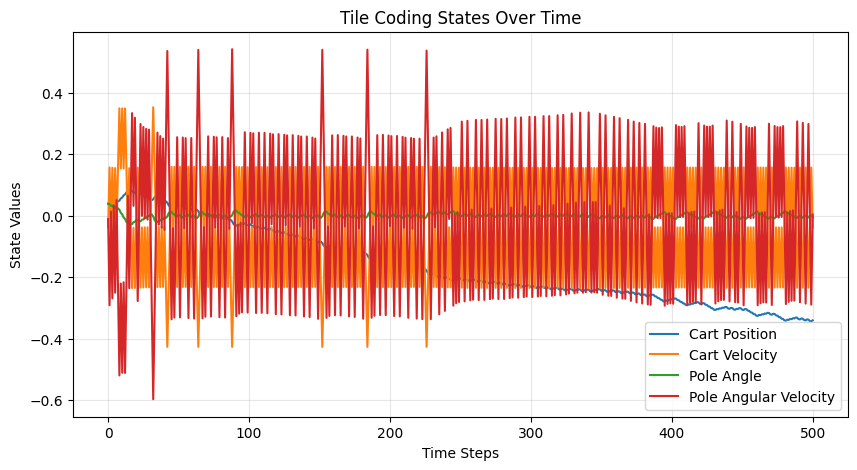

In [11]:
# Visualize the trained tile coding agent
tile_test_env = gym.make('CartPole-v1', render_mode='human')

# Run one episode to capture states for visualization
tile_state_history = []
state, info = tile_test_env.reset()

terminated = False
while not terminated:
    tile_state_history.append(state)
    action = tile_agent.choose_action(state, explore=False)
    state, reward, terminated, truncated, info = tile_test_env.step(action)
    terminated = terminated or truncated

tile_state_history.append(state)

# Plot the states over time
tile_state_history = np.array(tile_state_history)
plot_states_over_time(tile_state_history, title='Tile Coding States Over Time')
tile_test_env.close()